## 17.6 Classes for graphs

Looking at the worst-case complexities of the operations for the various graph
data structures, using a map of sets of out-neighbours is a clear winner:
all operations (except returning all edges) take
at most linear time in the number of nodes.
For some representations, the same operation is linear in the number of edges.
This takes longer for most graphs, which have more edges than nodes.

<div class="alert alert-warning">
<strong>Note:</strong> A graph algorithm with a complexity based on <em>n</em>, e.g. Θ(<em>n</em>²), is
preferable to an algorithm with the same complexity based on <em>e</em>, e.g. Θ(<em>e</em>²),
because <em>n</em> < <em>e</em> for most graphs.
</div>

Having decided the ADT's operations and how to represent graphs, I proceed to
define two Python classes, for digraphs and for undirected graphs.

### 17.6.1 The `DiGraph` class

My implementation of a digraph with an adjacency list representation is below.
Nodes must be represented by hashable objects due to the use of a dictionary.
Class `Hashable` in the `typing` module allows us to indicate
which function parameters must be hashable.

I've added a method to draw graphs, so that we can visually check them.
The method uses the [NetworkX](https://networkx.org/documentation) module,
which is included in the M269&nbsp;software but isn't part of Python's standard library.

Make sure you understand all the code, except the draw method.
You may wish to remind yourself of Python's
[dictionary and set operations](../08_Unordered/08_5_summary.ipynb).
If anything's unclear, ask in the M269 forums or tutorials.

In [1]:
# this code is also in m269_digraph.py

import networkx
from typing import Hashable

class DiGraph:
    """A directed graph with hashable node objects.

    Edges are between different nodes.
    There's at most one edge from one node to another.
    """

    def __init__(self):
        self.out = dict()   # a map of nodes to their out-neighbours

    def has_node(self, node: Hashable) -> bool:
        """Return True if and only if the graph has the node."""
        return node in self.out

    def has_edge(self, start: Hashable, end: Hashable) -> bool:
        """Return True if and only if edge start -> end exists.

        Preconditions: self.has_node(start) and self.has_node(end)
        """
        return end in self.out[start]

    def add_node(self, node: Hashable) -> None:
        """Add the node to the graph.

        Preconditions: not self.has_node(node)
        """
        self.out[node] = set()

    def add_edge(self, start: Hashable, end: Hashable) -> None:
        """Add edge start -> end to the graph.

        If the edge already exists, do nothing.

        Preconditions:
        self.has_node(start) and self.has_node(end) and start != end
        """
        self.out[start].add(end)

    def remove_node(self, node: Hashable) -> None:
        """Remove the node and all its attached edges.

        Preconditions: self.has_node(node)
        """
        for start in self.out:
            self.remove_edge(start, node)
        self.out.pop(node)

    def remove_edge(self, start: Hashable, end: Hashable) -> None:
        """Remove edge start -> end from the graph.

        If the edge doesn't exist, do nothing.

        Preconditions: self.has_node(start) and self.has_node(end)
        """
        self.out[start].discard(end)

    def nodes(self) -> set:
        """Return the graph's nodes."""
        all_nodes = set()
        for node in self.out:
            all_nodes.add(node)
        return all_nodes

    def edges(self) -> set:
        """Return the graph's edges as a set of pairs (start, end)."""
        all_edges = set()
        for start in self.out:
            for end in self.out[start]:
                all_edges.add( (start, end) )
        return all_edges

    def out_neighbours(self, node: Hashable) -> set:
        """Return the out-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return set(self.out[node])  # return a copy

    def out_degree(self, node: Hashable) -> int:
        """Return the number of out-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return len(self.out[node])

    def in_neighbours(self, node: Hashable) -> set:
        """Return the in-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        start_nodes = set()
        for start in self.out:
            if self.has_edge(start, node):
                start_nodes.add(start)
        return start_nodes

    def in_degree(self, node: Hashable) -> int:
        """Return the number of in-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return len(self.in_neighbours(node))

    def neighbours(self, node: Hashable) -> set:
        """Return the in- and out-neighbours of the node.

        Preconditions: self.has_node(node)
        """
        return self.out_neighbours(node).union(self.in_neighbours(node))

    def degree(self, node: Hashable) -> int:
        """Return the number of in- and out-going edges of the node.

        Preconditions: self.has_node(node)
        """
        return self.in_degree(node) + self.out_degree(node)

    def draw(self) -> None:
        """Draw the graph."""
        if type(self) == DiGraph:
            graph = networkx.DiGraph()
        else:
            graph = networkx.Graph()
        graph.add_nodes_from(self.nodes())
        graph.add_edges_from(self.edges())
        networkx.draw(graph, with_labels=True,
            node_size=1000, node_color='lightblue',
            font_size=12, font_weight='bold')

#### Exercise 17.6.1 (optional)

Here are some prompts to discuss your understanding of the code with others:

1. Why does the `out-neighbours` method waste memory and return a copy?
1. The in- and out-degree are computed as the number of in- and out-neighbours.
   Why doesn't the `degree` method just return the number of neighbours?
1. The `in_degree` method can be changed to run faster and use less memory. How?
1. Why did I implement `remove_edge` so that it works for non-existing edges?

_Write your answer here._

### 17.6.2 The `UndirectedGraph` class

Since an undirected graph can be represented as a digraph with opposing edges
between every pair of nodes, I implement a subclass of `DiGraph`
to reuse the representation and methods.

I must redefine the methods that add and remove edges, so that
they also add and remove the opposite edge.
Python's `super()` function allows us to access the methods of the superclass.
I must also reimplement other operations, to fit the
[definitions for undirected graphs](../17_Graphs_1/17_2_concepts.ipynb#17.2.1-On-nodes-and-edges).

In [2]:
# this code is also in m269_ungraph.py

from typing import Hashable

class UndirectedGraph(DiGraph):
    """An undirected graph with hashable node objects.

    There's at most one edge between two different nodes.
    There are no edges between a node and itself.
    """

    def add_edge(self, node1: Hashable, node2: Hashable) -> None:
        """Add an undirected edge node1-node2 to the graph.

        If the edge already exists, do nothing.

        Preconditions: self.has_node(node1) and self.has_node(node2)
        """
        super().add_edge(node1, node2)
        super().add_edge(node2, node1)

    def remove_edge(self, node1: Hashable, node2: Hashable) -> None:
        """Remove edge node1-node2 from the graph.

        If the edge doesn't exist, do nothing.

        Preconditions: self.has_node(node1) and self.has_node(node2)
        """
        super().remove_edge(node1, node2)
        super().remove_edge(node2, node1)

    def edges(self) -> set:
        """Return the graph's edges as a set of pairs.

        Postconditions: for every edge A-B,
        the output has either (A, B) or (B, A) but not both
        """
        all_edges = set()
        for node1 in self.out:
            for node2 in self.out[node1]:
                if (node2, node1) not in all_edges:
                    all_edges.add( (node1, node2) )
        return all_edges

    def in_neighbours(self, node: Hashable) -> set:
        """Return all nodes that are adjacent to the node.

        Preconditions: self.has_node(node)
        """
        return self.out_neighbours(node)

    def neighbours(self, node: Hashable) -> set:
        """Return all nodes that are adjacent to the node.

        Preconditions: self.has_node(node)
        """
        return self.out_neighbours(node)

    def in_degree(self, node: Hashable) -> int:
        """Return the number of edges attached to the node.

        Preconditions: self.has_node(node)
        """
        return self.out_degree(node)

    def degree(self, node: Hashable) -> int:
        """Return the number of edges attached to the node.

        Preconditions: self.has_node(node)
        """
        return self.out_degree(node)

#### Exercise 17.6.2 (optional)

You may wish to discuss the following with your study buddy or peers:

1. If the `in_neighbours` and `neighbours` methods had been inherited instead of
   reimplemented, would they work for undirected graphs?
   If so, why did I reimplement them?
2. Same questions, but for the `in_degree` and `degree` methods.

_Write your answer here._

### 17.6.3 Special graphs

We can now construct the
[special graphs](../17_Graphs_1/17_2_concepts.ipynb#17.2.3-Special-graphs) introduced earlier.

In [3]:
# this code is also in m269_graphs.py

EMPTY = UndirectedGraph()

def null_graph(n: int) -> UndirectedGraph:
    """Return a graph with nodes 0, 1, ..., n-1 and no edges.

    Preconditions: n > 0
    """
    graph = UndirectedGraph()
    for node in range(n):
        graph.add_node(node)
    return graph

def path_graph(n: int) -> UndirectedGraph:
    """Return a graph with nodes 0, ..., n-1 and edges 0–1, 1–2, ....

    Preconditions: n > 0
    """
    graph = null_graph(n)
    for node in range(n-1):
        graph.add_edge(node, node+1)
    return graph

def cycle_graph(n: int) -> UndirectedGraph:
    """Return a graph with nodes 0, ..., n-1 and edges 0–1, 1–2, ..., (n-1)–0.

    Preconditions: n > 0
    """
    graph = path_graph(n)
    graph.add_edge(n-1, 0)
    return graph

def complete_graph(n: int) -> UndirectedGraph:
    """Return a graph with nodes 0, ..., n-1 connected to each other.

    Preconditions: n > 0
    """
    graph = null_graph(n)
    for node1 in range(n):
        for node2 in range(node1 + 1, n):
            graph.add_edge(node1, node2)
    return graph

NetworkX draws graphs with the same `matplotlib` module I've used earlier to
[process images](../04_Iteration/04_8_practice.ipynb#4.8.6-Images).
We must tell Jupyter to draw the graphs in the notebook.

In [4]:
%matplotlib inline

If a code cell draws several graphs, only the last one is shown, so
we must draw one graph per cell.

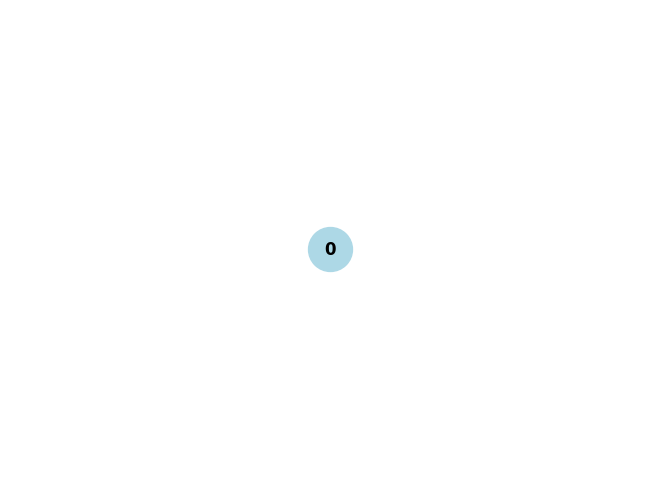

In [5]:
null_graph(1).draw()

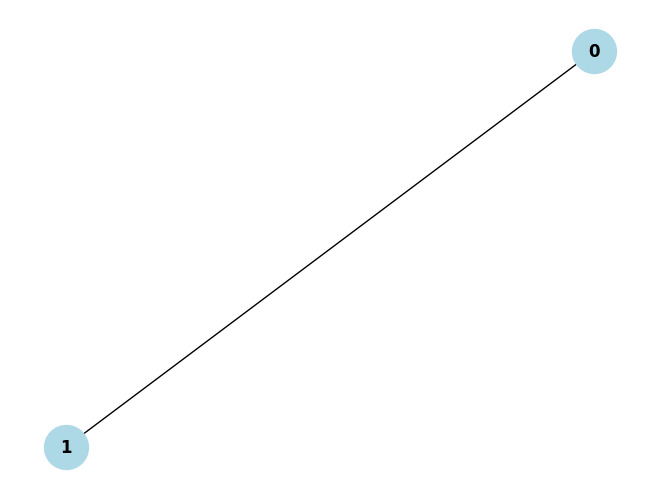

In [6]:
path_graph(2).draw()

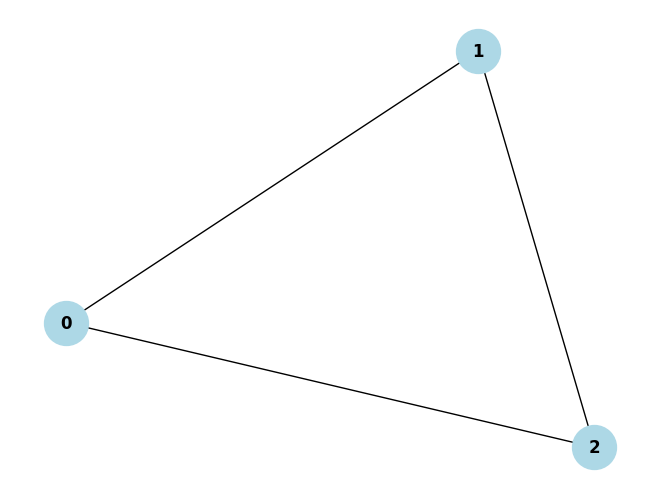

In [7]:
cycle_graph(3).draw()

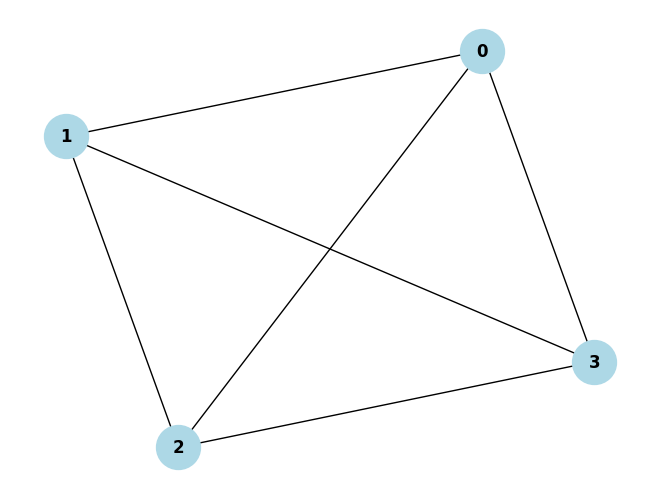

In [8]:
complete_graph(4).draw()

A graph's layout is computed from an initially random position of the nodes.
Every time you run a cell that draws a graph, the layout may change.

#### Exercise 17.6.3

Complete the function below.

In [9]:
from algoesup import test

def same_degree(graph: UndirectedGraph) -> bool:
    """Return True if and only if all nodes have the same degree.

    Preconditions: graph isn't empty
    """
    pass

same_degree_tests = [
    #case,          graph,        same degree?
    ('null',        null_graph(1),      True),  # all have degree 0
    ('path 2',      path_graph(2),      True),  # all have degree 1
    ('path 3',      path_graph(3),     False),
    ('cycle',       cycle_graph(3),     True),  # all have degree 2
    ('complete',    complete_graph(4),  True)   # all have degree 3
]

test(same_degree, same_degree_tests)

[Hint](../31_Hints/Hints_17_6_03.ipynb)
[Answer](../32_Answers/Answers_17_6_03.ipynb)

### 17.6.4 Random graphs

To test graph algorithms, it's useful to have less 'predictable' graphs.
We can generate a random graph by including each edge with some probability *p*.
(Remember that a probability is given by a real number from 0 to 1.)

The higher the *p* chosen, the denser the resulting graph is,
because of the larger likelihood for edges to be included.
What graphs are generated for *p* = 0 and for *p* = 1?

___

Those values of *p* generate a null graph and a complete graph, respectively.

Let's implement the approach, using function `random` in module `random` to
generate a float from 0 (inclusive) to 1 (exclusive).

In [10]:
# this code is also in m269_graphs.py

from random import random

def random_graph(n: int, probability: float) -> UndirectedGraph:
    """Generate a random graph with n nodes.

    Each edge has the given probability of existing.
    Preconditions: 0 <= probability <= 1
    """
    graph = null_graph(n)
    for node1 in range(n):
        for node2 in range(node1 + 1, n):
            if random() < probability:
                graph.add_edge(node1, node2)
    return graph

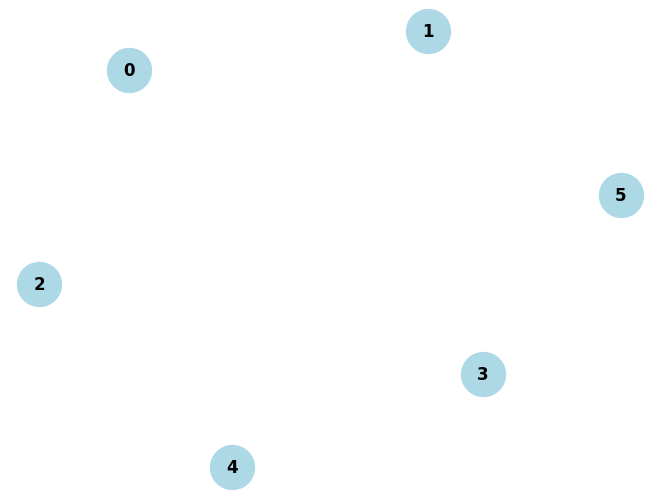

In [11]:
random_graph(6, 0).draw()   # p = 0%: no edges

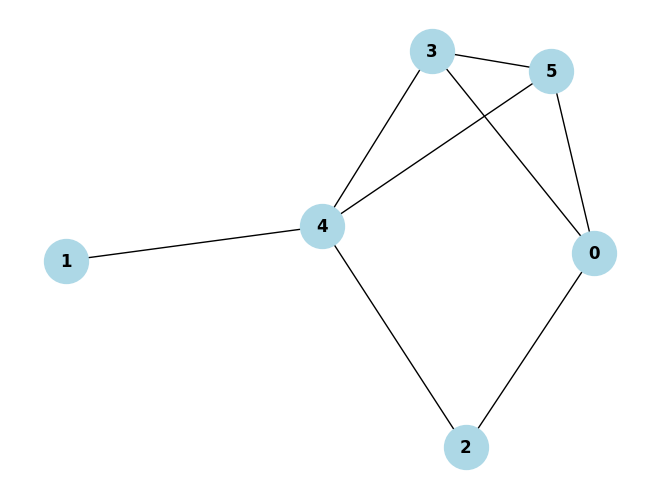

In [12]:
random_graph(6, 0.4).draw() # p = 40%

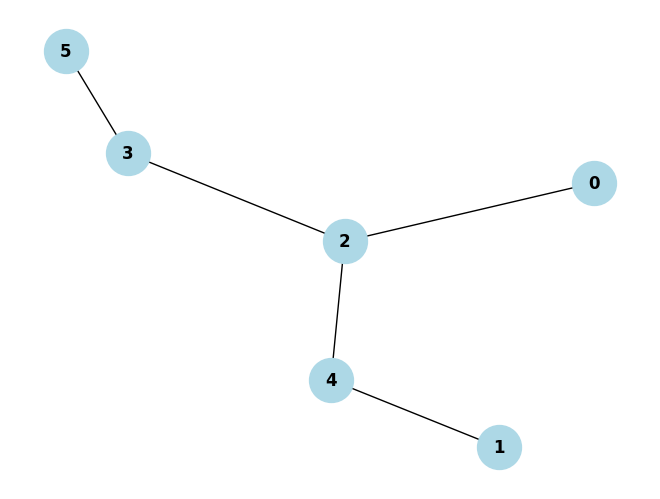

In [13]:
random_graph(6, 0.4).draw() # different graph for same n and p

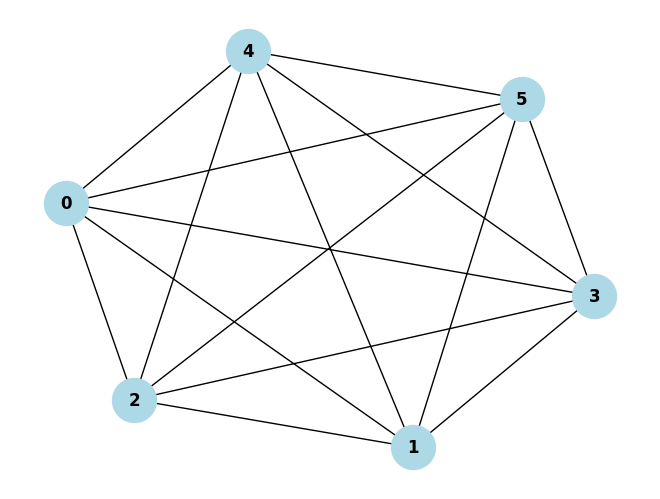

In [14]:
random_graph(6, 1).draw()   # p = 100%: all edges

<div class="alert alert-info">
<strong>Info:</strong> Edgar Gilbert proposed this random graph generation approach in 1959.
</div>

⟵ [Previous section](17_5_adj_list.ipynb) | [Up](17-introduction.ipynb) | [Next section](17_7_traversal.ipynb) ⟶